In [1]:
%matplotlib inline
from CMLTools import *

In [2]:
settings = Settings()
settings.freqs = np.arange(3, 25, 1)
settings.exp_list = ['FR1']
settings.time_range = (-750, 750)
settings.bin_Hz = 250
settings.spos_ranges = [[i] for i in range(1,13)]
settings.Save('test_fundamentals.json')

print('Frequencies:', settings.freqs)
print('Selected:', settings.exp_list)

sub_list_data = JSLoad(f'subject_list_{settings.expreg}.json')
subs_selected = sub_list_data['subs']
sub_list_counts = sub_list_data['sub_list_counts']


Frequencies: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Selected: ['FR1']


In [115]:
def OneSigma(circ_disp, N):
  scaled_sigma = np.sqrt(circ_disp/(N-1))
  if scaled_sigma >= 1:
    return np.pi/2
  retval = np.arcsin(scaled_sigma)*np.sqrt(N)
#  if retval > np.pi/2:
#    return np.pi/2
  #print('before', retval)
  #retval = 1/(1/retval + np.pi**2/(2*np.sqrt(N)))
  #print('after', retval)
  return retval

def PRayleigh(r, N):
  '''Adapted from Rizzuto's PhasePACK in eeg_toolbox.
     Also found in Greenwood and Durand, 1955, taking only through the n^-2 terms.'''
  Z = N*r*r
  return np.exp(-Z) * (1 + (2*Z - Z*Z) / (4*N) - (24*Z - 132*Z*Z + 76*Z**3 - 9* Z**4) / (288*N*N));

def OldPhaseConsistency(circ_disp, N):
  '''0 to 1, where 0 is the 1-sigma phase spread over half or more of the
     circle, and 1 is all points in one location.  0.5 is the 1-sigma
     spread occupying a 90-degree arc centered at the mean value, 0.75 is
     spread across a 45-degree arc, and so on.'''
  return 1 - OneSigma(circ_disp, N)/(np.pi/2)

def PolarHist(ang_arr, file, num_bins=None, title=None):
  autobin = False
  if num_bins is None:
    autobin = True
    num_bins = 2**int(np.floor(np.log2(len(ang_arr)/9.99999)))
    num_bins = min(max(num_bins, 16), 128)
  
  while True:
    h, bins = np.histogram(np.mod(ang_arr, 2*np.pi), num_bins, (0, 2*np.pi))
    if num_bins < 128 and (np.max(h) / len(ang_arr)) >= 0.20:
      num_bins *= 2
      continue
    bins = (bins[:num_bins]+bins[1:])/2
    break

  print(num_bins)
  hstr = ', '.join(str(e) for e in h)
  print(f'[{hstr}]')

  StartFig()
  ax = plt.subplot(111, projection='polar')
  bars = ax.bar(bins, h, width=2*np.pi/num_bins)
  if title is not None:
    plt.title(title)
  for b in bars:
    b.set_alpha(0.7)
  SaveFig(file)

  
def PhaseConsistencyTest(arr, N):
  '''Returns a shifted degree-of-freedom scaled Rayleigh z-score with average
     values ranging from 0 to 1, and with individual returned values with noise
     ranging 1 or less.  0 is the expectation value for no consistency in
     phase, while 1 is the value for perfect consistency in phase.  The
     averages of these phase consistency values are verified by simulation to
     be invariant across sample sizes of N>=2.  Adapted from Zar eq. 27.2'''
  Cbar = np.mean(np.real(arr))
  Sbar = np.mean(np.imag(arr))
  r_sqrd = Cbar*Cbar+Sbar*Sbar
  z = N*r_sqrd
  zs = (z-1)/(N-1)
  return zs


-4.863339781154286 10.212827162160973
2.1534404863552616
128
[10 10 14  8 11  8 10 11 10  9 12 11 13  7 16  7  7 11 13 13 11 10 14 14
 16 14  9 11 16  6 12  6 13 17 12 10 10 10  6  9 14 11 18 26 13 11  9 18
 15 15 18 11 17 23 19 14 13 13 10 19  7 13 19 19  8 14 14 15 19 14 11 15
 21 16 12 14 17 19 14 12 16 19 21 12 11 13 18 12  9 18 10 18 14 16 12 11
 10 26 13 13 15  7 14 10 12  6 11 13  8 10  7 14 13 12  9 10 11  8  8  5
 15  5  6 10  9  8  9  6]


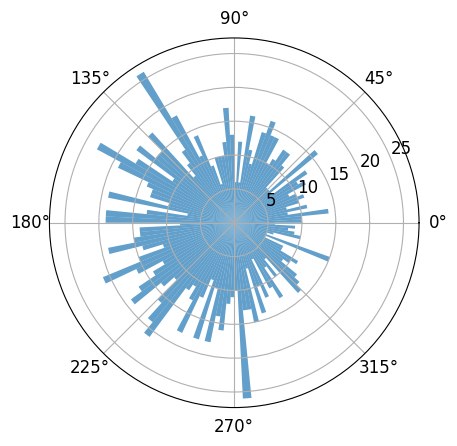

-2.986236463262144 9.599978087629015
2.129384007000188
128
[ 7 10 10  7  9  9  7  4 11  8  4 14 10  9  8 11  7  9 13  8 12 10  9 17
  8 10 15  8  9 10 11 12 12 17 18 10 13 17 16  8 11 11 14 13 17 11 21  9
 15 13 13 10 14 10 13 21 18 17 20 11 22  7 12 14  8 20 22 18 15 16 10 15
 15 15 19 15 15 21 19 12 12 15  8 18 21 14 15 14 11 12 13 15 14 15  9 15
 13 14  8 12 13 14 14  7  8 10 12  7 12 15 13 12  9 15 16 13  9 12 15  9
 12 15 12  7  7  9 12 14]


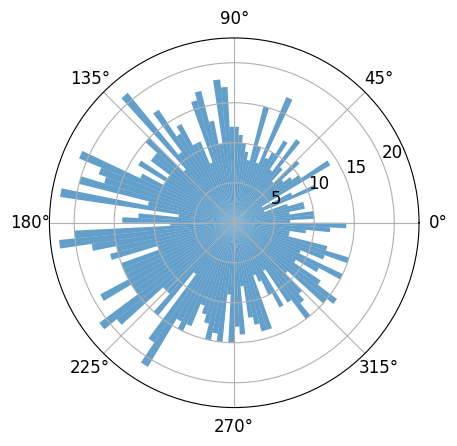

6.97049706376373 2.1441369860750337 -3.4375562540221605
ravg 0.10365504701373902
z_avg: 17.627315111154868
pr_avg: 1.4812155959979621e-05
zs_avg 0.010398571051378903
np.std(zs_arr): 0.003498218600318527
zs_arr < 1: 1.0
zs_arr > 2: 0.0


In [100]:
N = 1600
sigma = (np.pi/2)*1.38
sigma = (np.pi/2)*1.365
v = []
pc_arr = []
r_arr = []
e_arr = []
z_arr = []
zs_arr = []
pr_arr = []
for i in range(100):
  a = np.random.normal(np.pi, sigma, N)
  if i<2:
    #print(','.join(str(s) for s in a), CircularDispersion([np.cos(x) + 1j*np.sin(x) for x in a]))
    print(np.min(a), np.max(a))
    print(np.std(a, ddof=1))
    PolarHist(a, 'polar_hist')
  p = [np.cos(x) + 1j*np.sin(x) for x in a]
  r = np.abs(np.sum(p))/len(a)
  r_arr.append(r)
  z = N*r*r
  z_arr.append(z)
  zs = (z-1)/(N-1)
#  zs_arr.append(zs)
  zs_arr.append(PhaseConsistencyTest(p, N))
  pr = PRayleigh(r, N)
  pr_arr.append(pr)
  circ_disp = CircularDispersion(p)
  e = np.exp(-circ_disp)
  e_arr.append(e)
  onesig = OneSigma(circ_disp, N)
  pc = OldPhaseConsistency(circ_disp, N)
  #onesig = np.arcsin(np.sqrt(circ_disp))
  #v.append(1/(circ_disp+1))
  v.append(onesig)
  pc_arr.append(pc)
#print(circ_disp, PhaseSpread(circ_disp, N))
#print(1/(circ_disp+1))
print(np.mean(v), sigma, np.mean(pc_arr))
#print('v',v)
#print('r_arr',r_arr)
print('ravg', np.mean(r_arr))
#print('eavg,', np.mean(e_arr), 'e_arr', e_arr)
print('z_avg:', np.mean(z_arr))
#print('z_arr:', z_arr)
print('pr_avg:', np.mean(pr_arr))
#print('pr_arr:', pr_arr)
print('zs_avg', np.mean(zs_arr))
print('np.std(zs_arr):', np.std(zs_arr, ddof=1))
print('zs_arr < 1:', np.sum(np.array(zs_arr)<1)/len(zs_arr))
print('zs_arr > 2:', np.sum(np.array(zs_arr)>2)/len(zs_arr))
#print('zs_arr', zs_arr)

In [103]:
N = 1600
sigma = (np.pi/2)*1.365
zs1 = 0
while zs1 < 0.0099 or zs1 > 0.0101:
  a1 = np.random.normal(np.pi, sigma, N)%(2*np.pi)
  p1 = [np.cos(x) + 1j*np.sin(x) for x in a1]
  zs1 = PhaseConsistencyTest(p1, N)
print(zs1)

0.009947544742868393


[0.02454369 0.07363108 0.12271846 0.17180585 0.22089323 0.26998062
 0.319068   0.36815539 0.41724277 0.46633016 0.51541754 0.56450493
 0.61359232 0.6626797  0.71176709 0.76085447 0.80994186 0.85902924
 0.90811663 0.95720401 1.0062914  1.05537878 1.10446617 1.15355355
 1.20264094 1.25172832 1.30081571 1.34990309 1.39899048 1.44807786
 1.49716525 1.54625263 1.59534002 1.6444274  1.69351479 1.74260218
 1.79168956 1.84077695 1.88986433 1.93895172 1.9880391  2.03712649
 2.08621387 2.13530126 2.18438864 2.23347603 2.28256341 2.3316508
 2.38073818 2.42982557 2.47891295 2.52800034 2.57708772 2.62617511
 2.67526249 2.72434988 2.77343726 2.82252465 2.87161203 2.92069942
 2.96978681 3.01887419 3.06796158 3.11704896 3.16613635 3.21522373
 3.26431112 3.3133985  3.36248589 3.41157327 3.46066066 3.50974804
 3.55883543 3.60792281 3.6570102  3.70609758 3.75518497 3.80427235
 3.85335974 3.90244712 3.95153451 4.00062189 4.04970928 4.09879667
 4.14788405 4.19697144 4.24605882 4.29514621 4.34423359 4.39332

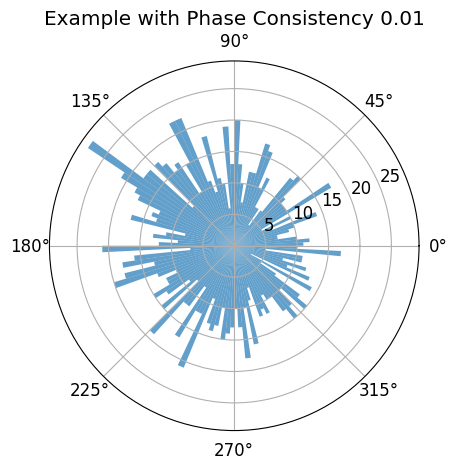

In [116]:
PolarHist(a1, 'polar_hist_0.01', title='Example with Phase Consistency 0.01')

In [89]:
N = 1600
sigma = (np.pi/2)*1.26
zs2 = 0
while zs2 < 0.0199 or zs2 > 0.0201:
  a2 = np.random.normal(np.pi, sigma, N)%(2*np.pi)
  p2 = [np.cos(x) + 1j*np.sin(x) for x in a2]
  zs2 = PhaseConsistencyTest(p2, N)
print(zs2)

0.02008250532663838


[0.02454369 0.07363108 0.12271846 0.17180585 0.22089323 0.26998062
 0.319068   0.36815539 0.41724277 0.46633016 0.51541754 0.56450493
 0.61359232 0.6626797  0.71176709 0.76085447 0.80994186 0.85902924
 0.90811663 0.95720401 1.0062914  1.05537878 1.10446617 1.15355355
 1.20264094 1.25172832 1.30081571 1.34990309 1.39899048 1.44807786
 1.49716525 1.54625263 1.59534002 1.6444274  1.69351479 1.74260218
 1.79168956 1.84077695 1.88986433 1.93895172 1.9880391  2.03712649
 2.08621387 2.13530126 2.18438864 2.23347603 2.28256341 2.3316508
 2.38073818 2.42982557 2.47891295 2.52800034 2.57708772 2.62617511
 2.67526249 2.72434988 2.77343726 2.82252465 2.87161203 2.92069942
 2.96978681 3.01887419 3.06796158 3.11704896 3.16613635 3.21522373
 3.26431112 3.3133985  3.36248589 3.41157327 3.46066066 3.50974804
 3.55883543 3.60792281 3.6570102  3.70609758 3.75518497 3.80427235
 3.85335974 3.90244712 3.95153451 4.00062189 4.04970928 4.09879667
 4.14788405 4.19697144 4.24605882 4.29514621 4.34423359 4.39332

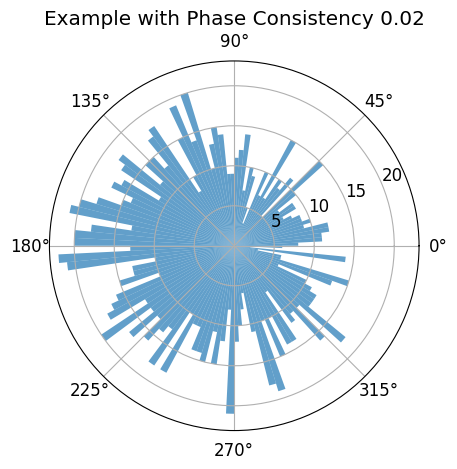

In [117]:
PolarHist(a2, 'polar_hist_0.02', title='Example with Phase Consistency 0.02')

In [91]:
N = 1600
sigma = (np.pi/2)*1.191
zs3 = 0
while zs3 < 0.0299 or zs3 > 0.0301:
  a3 = np.random.normal(np.pi, sigma, N)%(2*np.pi)
  p3 = [np.cos(x) + 1j*np.sin(x) for x in a3]
  zs3 = PhaseConsistencyTest(p3, N)
print(zs3)

0.030096099182335138


128
[4, 7, 5, 12, 4, 8, 9, 8, 10, 5, 9, 9, 3, 7, 11, 9, 10, 17, 11, 12, 9, 13, 11, 6, 10, 10, 13, 10, 12, 15, 12, 20, 8, 8, 11, 14, 14, 18, 16, 6, 17, 19, 14, 13, 15, 16, 27, 13, 16, 14, 17, 16, 19, 14, 11, 19, 23, 24, 21, 16, 12, 22, 11, 22, 16, 16, 15, 15, 18, 19, 15, 17, 15, 14, 10, 15, 12, 16, 11, 17, 17, 10, 14, 17, 16, 15, 13, 15, 16, 12, 11, 16, 12, 10, 16, 7, 8, 14, 20, 8, 17, 16, 7, 7, 9, 9, 10, 14, 10, 14, 10, 5, 4, 11, 14, 12, 6, 7, 13, 14, 8, 8, 8, 7, 10, 9, 8, 8]


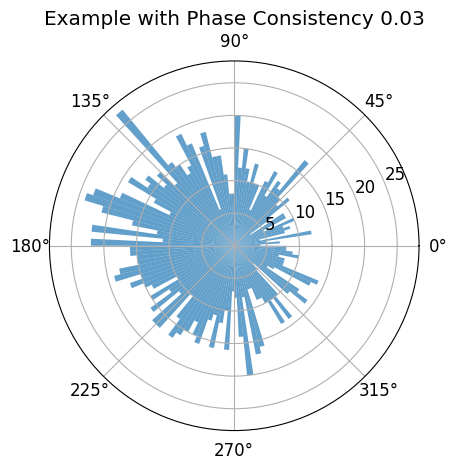

In [109]:
PolarHist(a3, 'polar_hist_0.03', title='Example with Phase Consistency 0.03')

In [96]:
N = 1600
sigma = (np.pi/2)*1.114
zs4 = 0
while zs4 < 0.0399 or zs4 > 0.0401:
  a4 = np.random.normal(np.pi, sigma, N)%(2*np.pi)
  p4 = [np.cos(x) + 1j*np.sin(x) for x in a4]
  zs4 = PhaseConsistencyTest(p4, N)
print(zs4)

0.03998767068740258


128
[12, 6, 7, 8, 9, 6, 8, 7, 6, 8, 7, 8, 8, 5, 6, 1, 11, 12, 8, 9, 5, 5, 14, 8, 10, 10, 10, 14, 9, 11, 11, 15, 12, 19, 21, 14, 14, 15, 13, 19, 11, 14, 19, 17, 20, 14, 15, 16, 13, 21, 24, 18, 16, 14, 26, 16, 17, 14, 18, 22, 16, 13, 14, 21, 17, 19, 16, 19, 14, 22, 14, 23, 10, 19, 13, 12, 15, 19, 18, 15, 14, 5, 19, 9, 15, 14, 17, 17, 18, 13, 17, 13, 9, 10, 16, 8, 15, 4, 11, 10, 10, 10, 12, 12, 10, 16, 10, 7, 11, 10, 16, 9, 10, 9, 6, 7, 10, 12, 8, 14, 9, 10, 6, 5, 9, 5, 7, 11]


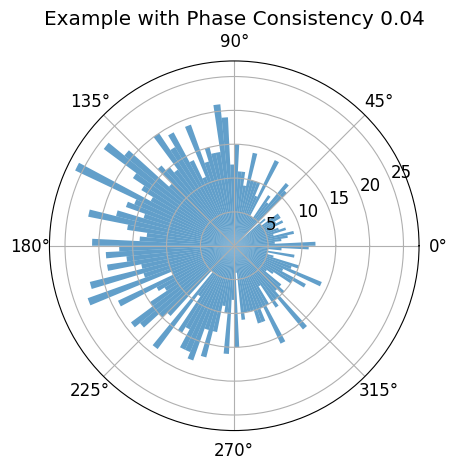

In [110]:
PolarHist(a4, 'polar_hist_0.04', title='Example with Phase Consistency 0.04')

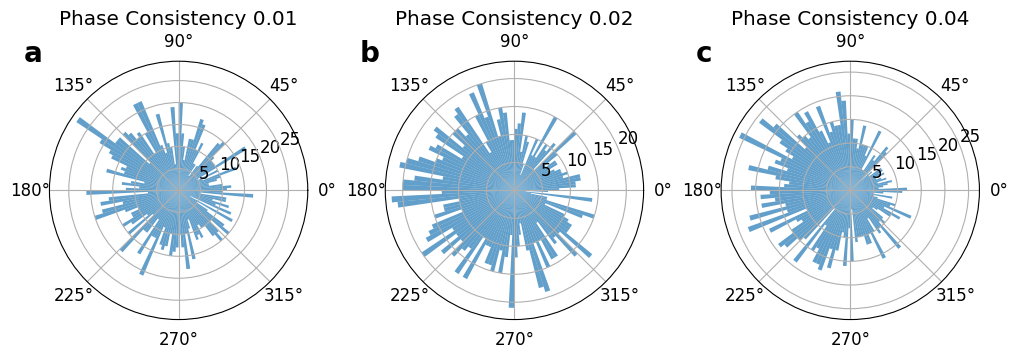

In [132]:
import string
# Lock down one random generation for plot:
num_bins = 128
bins = np.linspace(0, 2*np.pi, num_bins+1)[:-1] + 2*np.pi/(2*num_bins)
h1 = [11, 12, 10, 7, 7, 9, 10, 14, 6, 10, 5, 18, 10, 10, 10, 11, 15, 14, 7, 4, 7, 7, 12, 10, 16, 17, 12, 12, 7, 10, 13, 20, 13, 19, 6, 10, 11, 18, 9, 11, 22, 22, 15, 10, 16, 15, 17, 18, 9, 18, 18, 28, 21, 18, 17, 13, 14, 13, 17, 8, 11, 13, 9, 12, 21, 7, 16, 18, 13, 18, 20, 13, 10, 12, 12, 15, 13, 9, 15, 8, 19, 12, 12, 8, 17, 12, 12, 21, 9, 13, 14, 13, 10, 15, 14, 13, 10, 13, 18, 10, 16, 9, 7, 12, 11, 12, 9, 10, 10, 13, 15, 13, 10, 15, 13, 8, 5, 14, 3, 13, 9, 12, 8, 11, 11, 5, 17, 10]
h2 = [8, 11, 11, 12, 12, 9, 10, 9, 9, 8, 7, 9, 9, 7, 10, 15, 5, 11, 9, 10, 7, 15, 7, 10, 3, 5, 9, 10, 7, 14, 12, 11, 9, 9, 14, 15, 13, 10, 20, 14, 19, 15, 10, 8, 18, 17, 13, 15, 15, 12, 18, 17, 11, 16, 17, 14, 15, 18, 20, 21, 13, 18, 20, 20, 13, 22, 21, 10, 13, 13, 15, 10, 16, 17, 18, 13, 20, 13, 17, 13, 16, 14, 13, 18, 10, 18, 11, 11, 14, 14, 15, 11, 15, 12, 8, 21, 12, 10, 8, 6, 11, 18, 19, 10, 15, 10, 14, 14, 7, 12, 11, 16, 11, 18, 12, 12, 12, 11, 10, 6, 13, 15, 6, 6, 3, 14, 2, 6]
h3 = [4, 7, 5, 12, 4, 8, 9, 8, 10, 5, 9, 9, 3, 7, 11, 9, 10, 17, 11, 12, 9, 13, 11, 6, 10, 10, 13, 10, 12, 15, 12, 20, 8, 8, 11, 14, 14, 18, 16, 6, 17, 19, 14, 13, 15, 16, 27, 13, 16, 14, 17, 16, 19, 14, 11, 19, 23, 24, 21, 16, 12, 22, 11, 22, 16, 16, 15, 15, 18, 19, 15, 17, 15, 14, 10, 15, 12, 16, 11, 17, 17, 10, 14, 17, 16, 15, 13, 15, 16, 12, 11, 16, 12, 10, 16, 7, 8, 14, 20, 8, 17, 16, 7, 7, 9, 9, 10, 14, 10, 14, 10, 5, 4, 11, 14, 12, 6, 7, 13, 14, 8, 8, 8, 7, 10, 9, 8, 8]
h4 = [12, 6, 7, 8, 9, 6, 8, 7, 6, 8, 7, 8, 8, 5, 6, 1, 11, 12, 8, 9, 5, 5, 14, 8, 10, 10, 10, 14, 9, 11, 11, 15, 12, 19, 21, 14, 14, 15, 13, 19, 11, 14, 19, 17, 20, 14, 15, 16, 13, 21, 24, 18, 16, 14, 26, 16, 17, 14, 18, 22, 16, 13, 14, 21, 17, 19, 16, 19, 14, 22, 14, 23, 10, 19, 13, 12, 15, 19, 18, 15, 14, 5, 19, 9, 15, 14, 17, 17, 18, 13, 17, 13, 9, 10, 16, 8, 15, 4, 11, 10, 10, 10, 12, 12, 10, 16, 10, 7, 11, 10, 16, 9, 10, 9, 6, 7, 10, 12, 8, 14, 9, 10, 6, 5, 9, 5, 7, 11]
StartFig(figsize=(12,4))
plottups = [(h1, '0.01'), (h2, '0.02'), (h4, '0.04')]
for i,(h, label) in enumerate(plottups):
  ax = plt.subplot(1, len(plottups), i+1, projection='polar')
  bars = ax.bar(bins, h, width=2*np.pi/num_bins)
  plt.title(f'Phase Consistency {label}')
  ax.text(-0.2, 1.05, f'{string.ascii_lowercase[i]}.', transform=ax.transAxes, size=20, weight='bold')
  for b in bars:
    b.set_alpha(0.7)
plt.subplots_adjust(wspace=0.3)
SaveFig('polar_hists_range')

In [105]:
print('0.02 has', sum(e.real<0 for e in p2)/len(p2), 'to the left')
print('0.03 has', sum(e.real<0 for e in p3)/len(p3), 'to the left')
print('0.04 has', sum(e.real<0 for e in p4)/len(p4), 'to the left')

0.02 has 0.593125 to the left
0.03 has 0.6025 to the left
0.04 has 0.634375 to the left


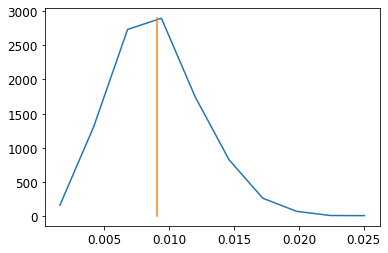

min 0.00030571737436539274 max 0.026335342287629678


In [994]:
StartFig()
h, bins = plt.histogram(zs_arr)
plt.plot((bins[:len(bins)-1]+bins[1:])/2, h)
plt.plot([np.mean(zs_arr)]*2, [0, max(h)])
SaveFig('normality_test_zs')
print('min', min(zs_arr), 'max', max(zs_arr))

In [959]:
print(h)
print(bins)
print(np.mean(zs_arr), np.sum(np.array(h)*(bins[:len(bins)-1]+bins[1:])/2)/np.sum(h))

[  45  496 1739 2786 2478 1569  622  198   52   15]
[0.02198675 0.03740094 0.05281512 0.06822931 0.0836435  0.09905769
 0.11447188 0.12988607 0.14530026 0.16071444 0.17612863]
0.08485340632977338 0.08481189692554704


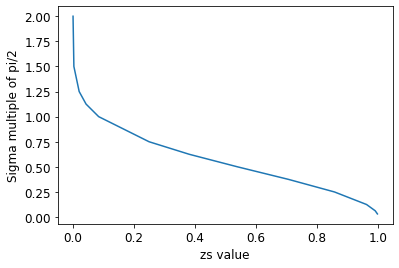

In [955]:
sigmult = [0.03125, 0.0625, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 1, 1.125, 1.25, 1.5, 2]
zsv = [0.9976, 0.9904, 0.962, 0.857, 0.7067, 0.5398, 0.3817, 0.250, 0.0850, 0.0437, 0.02113, 0.00379, 0.00106]
StartFig()
plt.plot(zsv, sigmult)
plt.xlabel('zs value')
plt.ylabel('Sigma multiple of pi/2')
SaveFig('zs_exploration')

In [956]:
def zs_to_sigma_mult(zs):
  if zs <= 0:
    return 0
  # Estimate
  return np.arccos(zs**0.5)/(np.pi/2)-np.log(zs)/(2*np.pi)
for zs,sigm in zip(zsv, sigmult):
  print(zs_to_sigma_mult(zs), sigm)

0.03158279165497201 0.03125
0.06401124750099292 0.0625
0.1310655533113621 0.125
0.2714420075478612 0.25
0.41959161095758807 0.375
0.5727637265863369 0.5
0.7293184489377713 0.625
0.8873022668193183 0.75
1.2039931459882531 1
1.3641484535670445 1.125
1.5210012813311031 1.25
1.8481337539487317 1.5
2.0693991119488846 2
